In [38]:
!pip install wget

In [39]:
import os
import re
from pathlib import Path
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import random
import wget
random.seed()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from pathlib import Path
import tempfile
import subprocess
import wget

import nltk
from nltk.stem import *
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download("wordnet")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [40]:
filename = wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/20_newsgroups.zip", "20_newsgroups.zip")
!unzip 20_newsgroups.zip
DATA_DIR = "20_newsgroups"

Archive:  20_newsgroups.zip
replace 20_newsgroups/talk.politics.mideast/75895? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Functions from lab

In [0]:
def clean_file_text(text):
    new_text = re.sub("Newsgroups:.*?\n", "", text)
    new_text = re.sub("Xref:.*?\n", "", new_text)
    new_text = re.sub("Path:.*?\n", "", new_text)
    new_text = re.sub("Date:.*?\n", "", new_text)
    new_text = re.sub("Followup-To:.*?\n", "", new_text)
    return new_text

In [0]:
def corpus_count_words(file_list):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            word_counter.update(file_words)
    return word_counter

In [0]:
def get_topic_name(file_path):
    return file_path.parent.name

def get_target(topic_name):
    topics = ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 
     'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 
     'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
     'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']
    return topics.index(topic_name)

In [0]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

## Q1

In [0]:
all_files = [pth for pth in Path(DATA_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [0]:
def binary_baseline_data(file_list, num_words = 1000):
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    return X, y

In [47]:
# get the baseline data
X, y = binary_baseline_data(all_files)

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9144816746445666
Test accuracy: 0.6876666666666666


### Q1 (a)

[Write your answer here]

Feature Set: the top 1000 most common words based on word frequency

Feature Encoding: binary encoding, 1 if the word appears, and 0 otherwise

Amount of Data: 19997 in total

Hyperparameters: C=1.0 which is the inverse of Lambda regulator, used to reduce overfitting

### Q1 (b)

Modify the following function:

In [0]:
def binary_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    porter = PorterStemmer()  # uses Suffix Stripping to produce stem 
                              #PorterStemmer is simple and fast
    stop_words = set(stopwords.words('english')) # set stop words in English
    
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(porter.stem(file_data))
            word_tokens = tokenizer.tokenize(file_data)
            file_words = [w for w in word_tokens if not w in stop_words]
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q1 (c)

Modify the following partial code to calculate the train and test accuracy and answer the question in the markdown cell below

In [49]:
# get the baseline data
X, y = binary_improved_data(all_files)

# Write your code here:
# You need to split the data and train a logistic regression classifier.
# Then, you need to calculate the variables train_accuracy and test_accuracy for the new classifier


# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0).fit(X_train, y_train)

# predict on train and test set
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

# calculate train and test accuracy
train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)


# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.933128527541616
Test accuracy: 0.8138333333333333


[Write your answer here]

Both train and test accuray improved, while the test accuracy is improved a lot with an increase of 18.1% compared to Q1(a). Besides, the difference of train and test accuracy is not that huge as Q1(a), as Q1(a) results is a bit overfitting.

### Q1 (d)

Modify the partial code below

In [0]:
def random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    
    
    # Write your code here
    
    for i in range(num_tests):

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

      clf = LogisticRegression(C=1.0).fit(X_train, y_train)

      y_train_predict = clf.predict(X_train)
      y_test_predict = clf.predict(X_test)

      train_accuracy = accuracy_score(y_train, y_train_predict)
      test_accuracy = accuracy_score(y_test, y_test_predict)

      train_results.append(train_accuracy)
      test_results.append(test_accuracy)

    
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q1 (e)

Use the following code to calculate the mean accuracy and 95% confidence interval over 10 random splits

In [51]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9314924626705723
Train confidence interval over 10 random splits: [0.9302634036127211, 0.9327215217284235]
Test mean accuracy over 10 random splits: 0.81555
Test confidence interval over 10 random splits: [0.8118524725951979, 0.8192475274048021]


[ Write your answer here ]

The 95% CI interval can tell that we can be 95% certain the true mean is in this range. 

Yes, they are more informative than a single trial, the more tests we have, the more informative the results will be. If we do different train-test splits, we may have all data trained across all interations, so the results of mean and 95% CI will be stablize if the number of tests is very large.

### Q1 (f)

Modify the partial code below

In [0]:
def random_cm(X, y, num_tests):
    # cm_list is a list of confusion matrices for the different random splits of the dataset
    cm_list = []
    
    # Write your code here
    
    for i in range(num_tests):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))
      clf = LogisticRegression(C=1.0).fit(X_train, y_train)
      y_train_predict = clf.predict(X_train)
      y_test_predict = clf.predict(X_test)
      
      cm = confusion_matrix(y_test, y_test_predict)
      
      cm_list.append(cm)
    
    # sum the confusion matrices and return the combined confusion matrix
    combined_cm = pd.Panel(cm_list).sum(axis=0)
    
    # validate return type
    assert isinstance(combined_cm, pd.DataFrame), "return type"
    
    return combined_cm

### Q1 (g)

Use the following code to produce a confusion matrix for 10 random splits

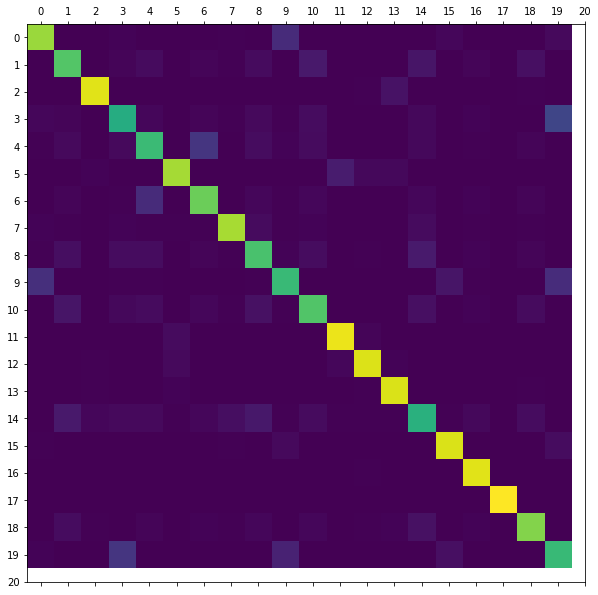

In [53]:
cm10 = random_cm(X, y, num_tests = 10)
plot_confusion_matrix(cm10)

In [54]:
pd.DataFrame(cm10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2543,3,1,27,0,0,0,14,8,372,1,1,0,0,3,51,6,0,0,71
1,5,2182,0,43,86,4,40,21,87,9,199,1,0,4,173,4,40,0,124,2
2,0,0,2847,0,0,7,0,1,0,1,0,3,21,146,2,0,0,0,16,0
3,47,39,1,1846,55,0,38,16,75,14,97,0,0,0,62,6,30,2,8,627
4,23,75,5,71,2040,2,456,5,104,35,85,0,9,3,68,0,13,0,41,1
5,1,0,24,0,0,2579,0,3,2,0,0,223,63,59,1,0,0,0,0,0
6,1,46,0,17,366,0,2321,3,49,20,58,0,1,0,50,1,24,1,36,3
7,26,18,4,32,18,13,14,2598,83,15,28,4,9,8,90,10,13,0,15,5
8,22,116,1,96,96,5,46,15,2129,31,97,4,18,1,211,0,26,0,36,1
9,401,4,0,16,13,1,0,10,15,2024,3,0,0,0,0,173,12,0,0,376


In [0]:
topics = ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 
     'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 
     'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
     'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']

In [56]:
confuse_class = [topics[0],topics[3],topics[4],topics[6],topics[9],topics[19]]
print(confuse_class)

['talk.politics.mideast', 'alt.atheism', 'rec.sport.baseball', 'rec.sport.hockey', 'talk.politics.misc', 'talk.religion.misc']


[ Write your answer here ]


1.   class 0, 9, both talks about politics, highly likely cover a huge number of similar words
2.   class 3, 19, atheism (an absence of belief in the existence of deities) and religion is similar  topics 
3.   class 9, 19, topics may have overlap becuase religion and politics are very close-related under some circumstances
4.   class 4, 6, both talks about sport



## Q2

### Q2 (a)

Modify the partial code below

In [0]:
def feature_num(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for p in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
        subset_size = int(p*X.shape[1])
        X_train_subset = X_train.iloc[:, 0:subset_size]
        X_test_subset = X_test.iloc[:, 0:subset_size]
        # Write your code here to calculate train_accuracy and test_accuracy for the current subset of features
        
        clf = LogisticRegression(C=1.0).fit(X_train_subset, y_train)
        y_train_predict_subset = clf.predict(X_train_subset)
        y_test_predict_subset = clf.predict(X_test_subset)
      
        train_accuracy = accuracy_score(y_train, y_train_predict_subset)
        test_accuracy = accuracy_score(y_test, y_test_predict_subset)
       
        # add to result_list
        result_list.append((p, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["num_features", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q2 (b)

Use the following code to plot the train and test accuracy for the different feature sets sizes

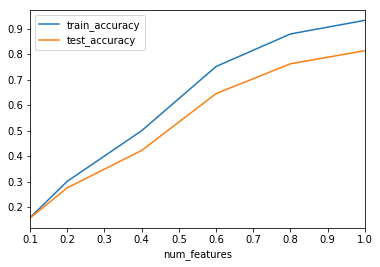

In [58]:
feature_num_df = feature_num(X, y)
feature_num_df.plot(x="num_features", y=["train_accuracy", "test_accuracy"])

[ Write your answer here ]

The performance will increase as more features input.

## Q3

### Q3 (a)

Modify the partial code below

In [0]:
def hyperparameter(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        # Write your code here to calculate train_accuracy and test_accuracy for the current parameter value
            
        clf = LogisticRegression(C=param).fit(X_train, y_train)
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)
      
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)
       
        # add to result_list
        result_list.append((param, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])
    
    # validate return type
    assert isinstance(result_df, pd.DataFrame), "return type"
    
    return result_df

### Q3 (b)

Use the following code to plot the train and test accuracy for the different the parameters

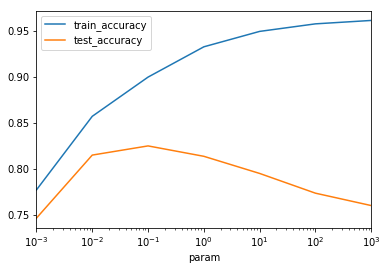

In [60]:
param_df = hyperparameter(X, y)
param_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

[ Write your answer here ]

C is a inverse regularization parameter applied to reduce the overfitting. It is a control variable that retains strength modification of regularization by being positioned to the lambda regulator.
The performance is best with parameter C=0.1, as C greater than 0.1, the model is getting overfitting due to weakening Lambda regulator, while C is smaller than 0.1, the model is underfitting as Lambda regulator strengthening.

## Q4

### Q4 (a)

Modify the partial code below

In [61]:
X.head()

,the,to,of,a,and,I,is,in,that,AX,edu,it,for,you,on,be,com,s,have,are,not,with,t,The,this,1,as,or,was,From,Subject,ID,Message,Lines,Organization,they,but,by,can,In,...,INS,Smith,assume,yourself,worth,guy,wasn,box,error,involved,values,week,1993Apr5,move,doubt,taking,w,Eric,g,37,test,coming,05,action,1993Apr17,Thomas,uchicago,01,United,BATF,friend,HP,isc,present,shall,outside,cars,weapons,recently,Summary
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
def tf_improved_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    
    
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    porter = PorterStemmer()  # uses Suffix Stripping to produce stem 
                              #PorterStemmer is simple and fast
    stop_words = set(stopwords.words('english')) # set stop words in English
    
    df_rows = []
    freqlist = {}
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(porter.stem(file_data))
            word_tokens = tokenizer.tokenize(file_data)
            file_words = [w for w in word_tokens if not w in stop_words]
            for wd in file_words:
              if wd in freqlist:
                freqlist[wd] = freqlist[wd]+1
              else:
                 freqlist[wd] = 0 
            df_rows.append([freqlist[word] if word in file_words else 0 for word in word_list]) 
            
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [get_target(get_topic_name(file_path)) for file_path in file_list]
    
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q4 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [63]:
X, y = tf_improved_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9996070586554261
Train confidence interval over 10 random splits: [0.9995337842301084, 0.9996803330807438]
Test mean accuracy over 10 random splits: 0.9186666666666667
Test confidence interval over 10 random splits: [0.9164038114149837, 0.9209295219183498]


[ Write your answer here ]

Comapred to binary encoding, term-frequency encoding performed better with a higher accuracy for both train and test data. This is obvious and intuitive to understand that frequncy is a better feature, as binary can only tells whether the word appears or not, while frequency can tell how closely-related the word to the topic.  

## Q5

### Q5 (a)

Modify the partial code below

In [0]:
def nb_random_mean_ci(X, y, num_tests):
    # train_results is a list of train accuracy results for the differrent random splits of the dataset
    train_results = []
    
    # test_results is a list of test accuracy results for the differrent random splits of the dataset
    test_results = []
    
    # Write your code here
    
    for i in range(num_tests):

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

      clf = GaussianNB().fit(X_train, y_train)

      y_train_predict = clf.predict(X_train)
      y_test_predict = clf.predict(X_test)

      train_accuracy = accuracy_score(y_train, y_train_predict)
      test_accuracy = accuracy_score(y_test, y_test_predict)

      train_results.append(train_accuracy)
      test_results.append(test_accuracy)
    
    
    # calculate the train mean and the 95% confidence interval for the list of results
    train_mean = np.mean(train_results)
    train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))
    
    # calculate the test mean and the 95% confidence interval for the list of results
    test_mean = np.mean(test_results)
    test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))
    
    # validate return types
    assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
    assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"
    
    return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

### Q5 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [65]:

train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = nb_random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9323140673001357
Train confidence interval over 10 random splits: [0.9304647122631013, 0.93416342233717]
Test mean accuracy over 10 random splits: 0.9089
Test confidence interval over 10 random splits: [0.9056541667268082, 0.9121458332731919]


[ Write your answer here ]

NB model performed worse than LR model, as NB model assumes the features are conditionally independent, but real data sets are never perfectly independent but they can be close. NB has a higher bias and lower variance compared to LR.

## Q6

### Q6 (a)

Modify the partial code below

In [0]:
def binary_med_data(file_list, num_words = 1000):
    # Put your code here
    # Make sure you update the variable features and targets below
    
    # Calculate word count in corpus
    news_cnt = corpus_count_words(file_list)
    
    # Select the most common numWords
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    tokenizer = RegexpTokenizer(r'\w+')
    porter = PorterStemmer()  # uses Suffix Stripping to produce stem 
                              #PorterStemmer is simple and fast
    stop_words = set(stopwords.words('english')) # set stop words in English
    
    df_rows = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(porter.stem(file_data))
            word_tokens = tokenizer.tokenize(file_data)
            file_words = [w for w in word_tokens if not w in stop_words]
            df_rows.append([1 if word in file_words else 0 for word in word_list])      
    X = pd.DataFrame(df_rows, columns = word_list)
    
    # Create a dataframe of targets (y)
    y = [1 if get_topic_name(file_path)=='sci.med' else 0 for file_path in file_list]
    
    
    
    # validate return types
    assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
    
    return X, y

### Q6 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [67]:
X, y = binary_med_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9856040580124313
Train confidence interval over 10 random splits: [0.9850108494235151, 0.9861972666013475]
Test mean accuracy over 10 random splits: 0.9704166666666666
Test confidence interval over 10 random splits: [0.969508232590938, 0.9713251007423952]


[ Write your answer here ]

The results performance of binary logistic regression got much better than previous multiclass models. However, since it is a binary classification model, we only have two classes "sci.med" and "others", and found that the classes are very imbalance, that's also explained why the accuracy is so high.